# Read in the data

In [1]:
#solutions at: https://github.com/dataquestio/solutions/blob/master/Mission217Solutions.ipynb
import pandas as pd
import numpy
import re
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
print(combined.head(1))

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score SchoolName  \
0                404.0                   363.0     1122.0          0   

   AP Test Takers   Total Exams Taken    ...     \
0       129.028846         197.038462    ...      

                                priority04                       priority05  \
0  Then to Manhattan students or residents  Then to New York City residents   

  priority06 priority07  priority08 priority09 priority10  \
0          0          0           0          0          0   

                                          Location 1        lat       lon  
0  220 Henry Street\nNew York, NY 10002\n(40.7137...  40.713764 -73.98526  

[1 rows x 159 columns]


# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
sorted_corr = correlations[survey_fields].sort_values(ascending=True)

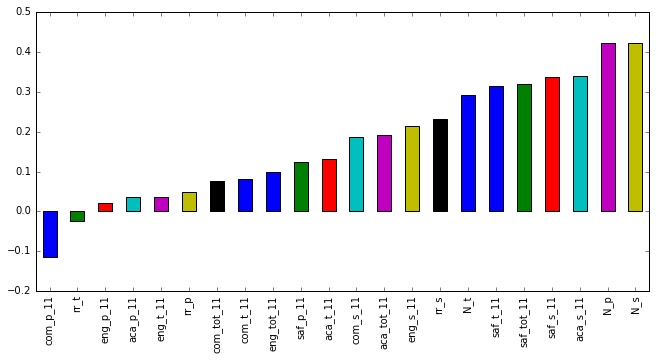

In [11]:
sorted_corr.plot(kind='bar',
                 figsize=(11,5))

Highest correlations seem to be N_s, N_p, aca_s_11, saf_s_11, saf_tot_11, saf_t_11, and N_t.

Weakest Correlations are with rr_t, eng_p_11, aca_p_11, eng_t_11.

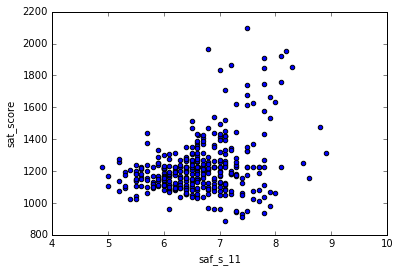

In [12]:
#Plotting the safety scores compared to the SAT Scores to see if there's a correlation.
combined.plot.scatter(x='saf_s_11', y='sat_score')

#Does seem that there is a correlation between the Safety Score and
#the SAT Score.

In [13]:
grouped = combined.groupby('school_dist').agg(numpy.mean).reset_index()
#print(combined.groupby('school_dist').agg(numpy.mean))

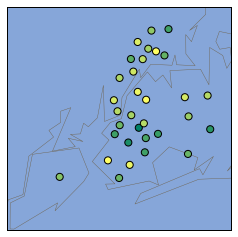

In [14]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#86A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = grouped['lon'].tolist()
latitudes = grouped['lat'].tolist()

m.scatter(longitudes, latitudes, 
          s=50, 
          zorder=2, 
          latlon=True,
         c=grouped['saf_s_11'],
         cmap='summer')


Need to check out which districts are showing the higher safety scores, and which are showing lower.

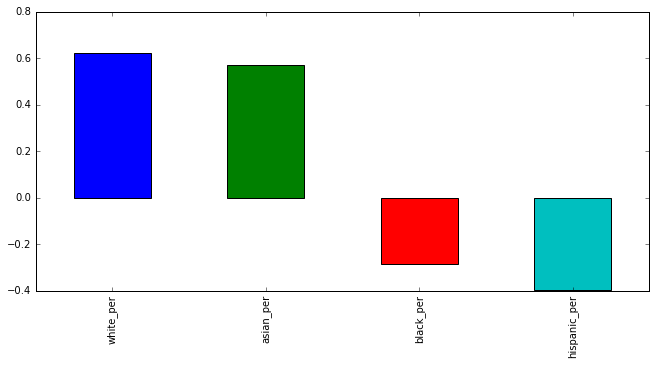

In [15]:
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot(kind='bar',
                 figsize=(11,5))

Looks like there are strong positive correlations between the percentage of whites and asians to the SAT scores of the schools, and weaker negative correlations with the black and hispanic percentages. Strongest negative correlation is with hispanic percentage.

In [23]:
hispanic_per = combined[combined['hispanic_per'] > 95].reset_index()
print(hispanic_per[['school_name', 'hispanic_per', 'sat_score']])

                                         school_name  hispanic_per  sat_score
0                      Manhattan Bridges High School          99.8     1058.0
1   Washington Heights Expeditionary Learning School          96.7     1174.0
2  Gregorio Luperon High School for Science and M...          99.8     1014.0
3                Academy for Language and Technology          99.4      951.0
4              International School for Liberal Arts          99.8      934.0
5   Pan American International High School at Monroe          99.8      970.0
6                          Multicultural High School          99.8      887.0
7             Pan American International High School         100.0      951.0


These seem to be schools that aim to be very inviting to recent immigrants, and serve a large population of English language learners. 

In [24]:
hispanic_per_10 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)].reset_index()
print(hispanic_per_10[['school_name', 'hispanic_per', 'sat_score']])

                                         school_name  hispanic_per  sat_score
0                             Stuyvesant High School           2.4     2096.0
1                       Bronx High School of Science           7.2     1969.0
2                     Brooklyn Technical High School           7.9     1833.0
3  Queens High School for the Sciences at York Co...           7.9     1868.0
4                Staten Island Technical High School           5.3     1953.0


These schools seem to have a tendency to emphasize the sciences/engineering/technology. They range from being considered "pressure cooker" schools, to being very rigorous but with supports for students.

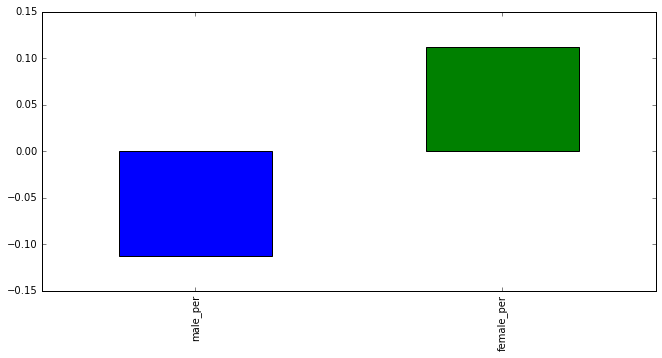

In [25]:
correlations[['male_per', 'female_per']].plot(kind='bar',
                 figsize=(11,5))

Fairly moderate correlations between the gender percentages. Seems to be a weak negative correlation for the male percentage in schools, and a weak positive correlation for the femaile percentage.

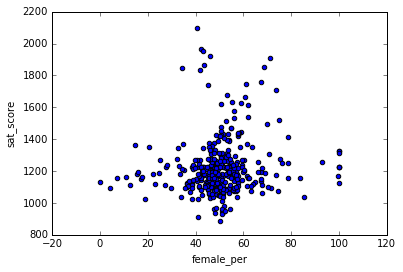

In [26]:
combined.plot.scatter(x='female_per', y='sat_score')

Doesn't look like there's much of a correlation between female percentage and SAT score. Some of the highest scoring schools seem to have a slightly lower percenatage of females. The ones with 40% or less seem not to get much past 1400. The ones with over 50% females can climb up to just below 2000.

In [30]:
female_percent = combined[
    (combined['female_per'] > 60) & 
    (combined['sat_score'] > 1700)].reset_index()
print(female_percent[['school_name', 'female_per', 'sat_score']])

                                         school_name  female_per  sat_score
0                     Bard High School Early College        68.7     1856.0
1                      Eleanor Roosevelt High School        67.5     1758.0
2                                 Beacon High School        61.0     1744.0
3  Fiorello H. LaGuardia High School of Music & A...        73.6     1707.0
4                        Townsend Harris High School        71.1     1910.0


These schools have much less of an emphasis on the sciences/technology. The higher female percentages have a bigger focus on the arts and humanities. The schools in the 60-70% female range have a more standard high school curriculum, but are accelerated.

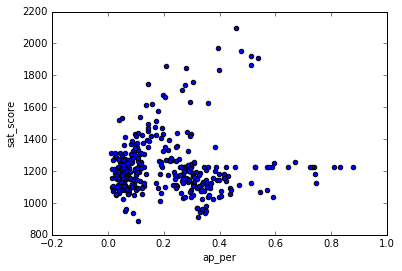

In [32]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

combined.plot.scatter(x='ap_per', y='sat_score')

There are two lines, where the increasing percentage of AP Test takers either has a strong positive correlation, or just creates a flat line. The higher AP percentages seem to hover around 1250 score, while the highest scores peak a